In [1]:
print('Hello World')

Hello World


In [2]:
!pip install -qq transformers


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 4
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
df =pd.read_csv('/kaggle/input/data-reviews/reviews123.csv')
df.head(2)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [6]:
print(df.score.value_counts())

3    5042
5    2900
4    2776
1    2566
2    2462
Name: score, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='score', ylabel='count'>

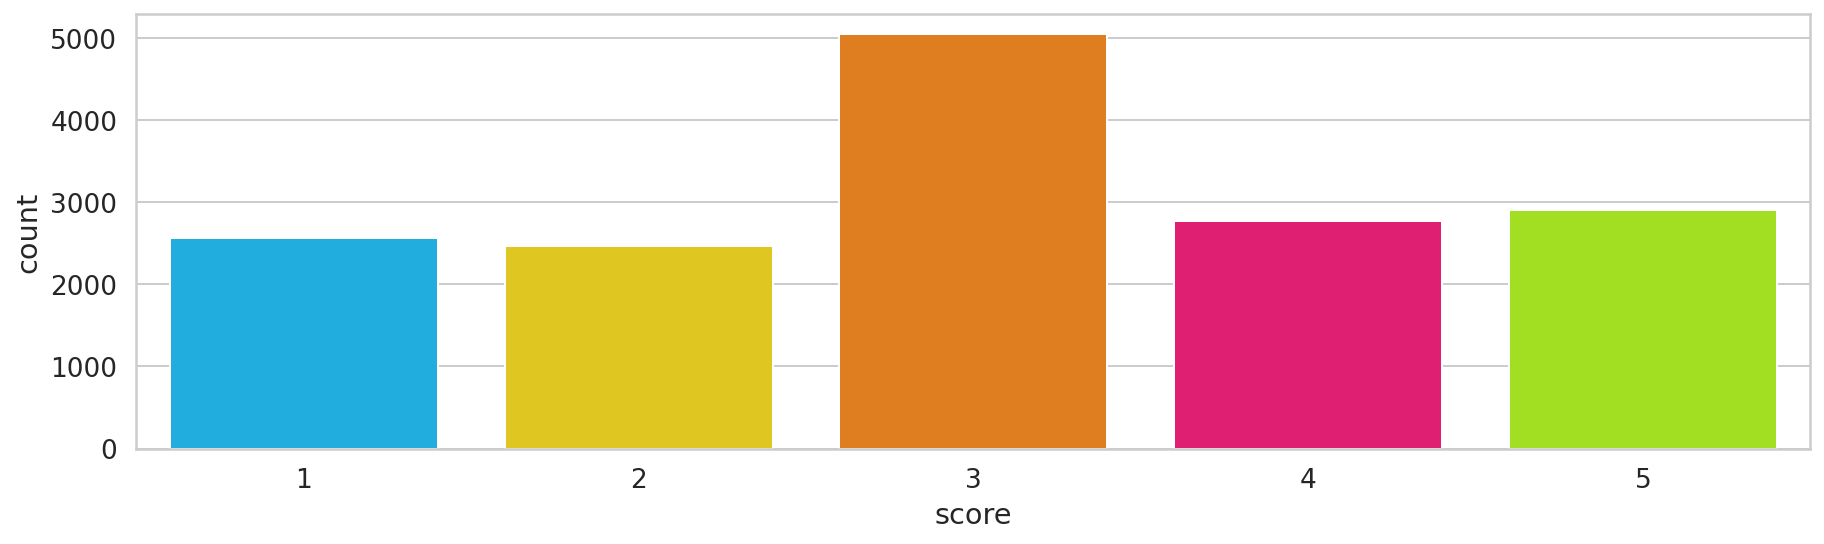

In [7]:
sns.countplot(df.score)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


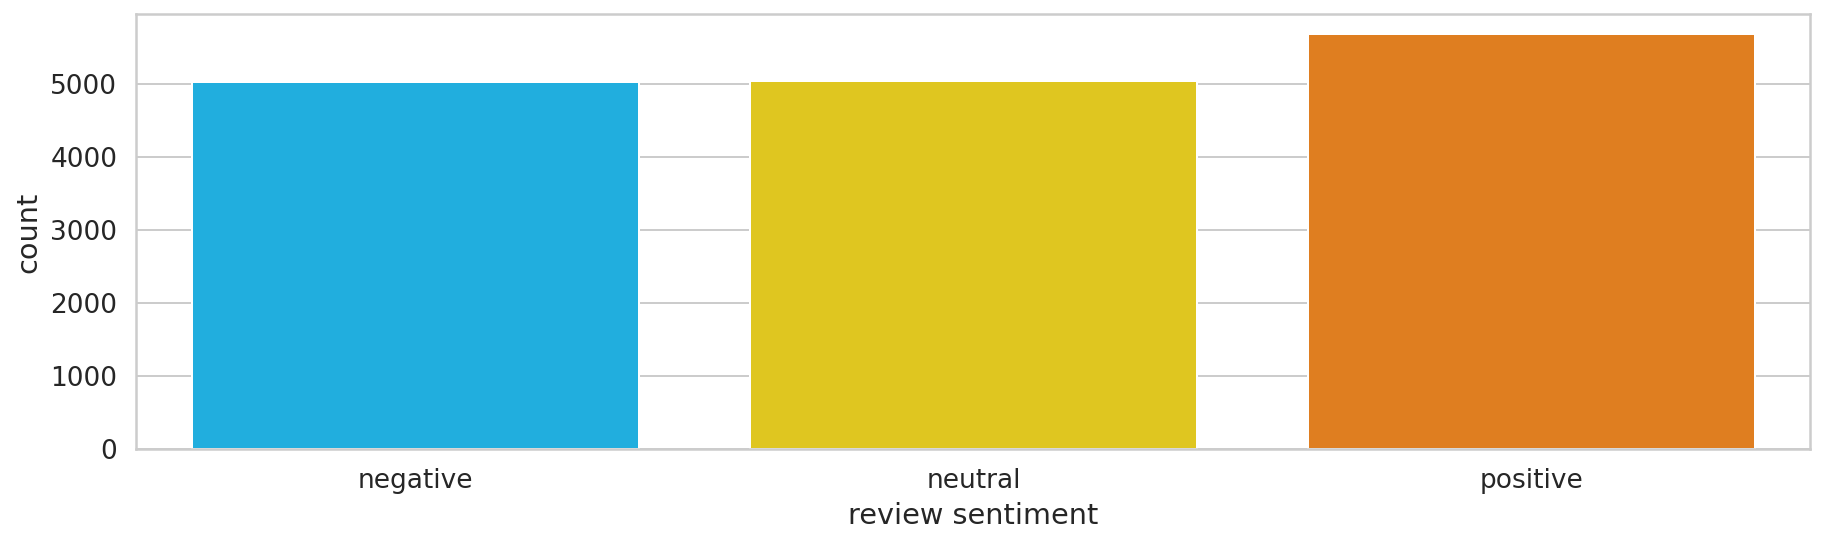

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2
df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

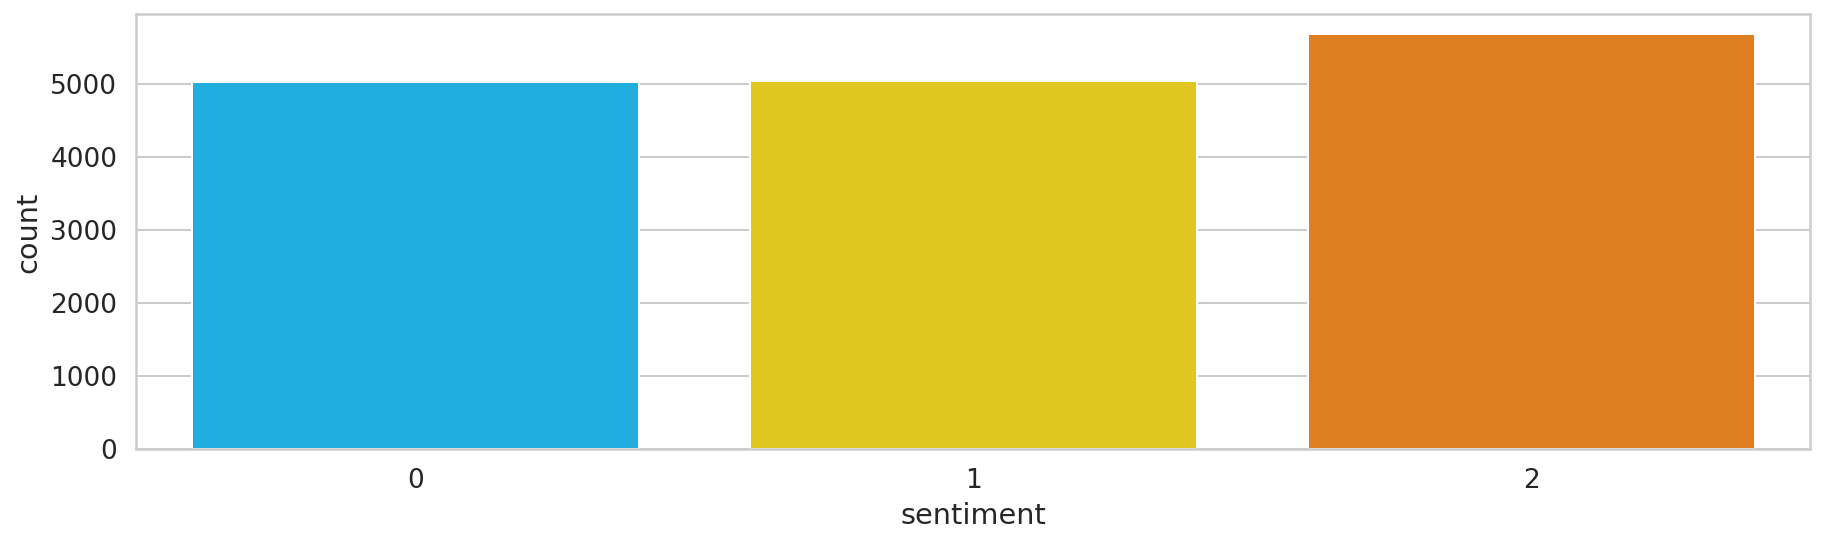

In [9]:
sns.countplot(df.sentiment)

In [10]:
classes=['negetive','neutral','positive']

In [11]:
print(df.content.isnull().sum(),df.sentiment.isnull().sum())

0 0


In [12]:
Tokenizer= BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
simple_text='it is said mothers teachers and preachers have changed the destiny of nations'

In [14]:
tokens=Tokenizer.tokenize(simple_text)
token_ids=Tokenizer.convert_tokens_to_ids(tokens)
print(simple_text)
print(tokens)
print(token_ids)

it is said mothers teachers and preachers have changed the destiny of nations
['it', 'is', 'said', 'mothers', 'teachers', 'and', 'preacher', '##s', 'have', 'changed', 'the', 'destiny', 'of', 'nations']
[1122, 1110, 1163, 12694, 4952, 1105, 18154, 1116, 1138, 2014, 1103, 16988, 1104, 6015]


In [15]:
encoding= Tokenizer.encode_plus(simple_text,
                               max_length=32,
                               pad_to_max_length=True,
                               return_attention_mask=True,
                               add_special_tokens=True,
                               return_token_type_ids=False,
                               return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [17]:
encoding['input_ids']

tensor([[  101,  1122,  1110,  1163, 12694,  4952,  1105, 18154,  1116,  1138,
          2014,  1103, 16988,  1104,  6015,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

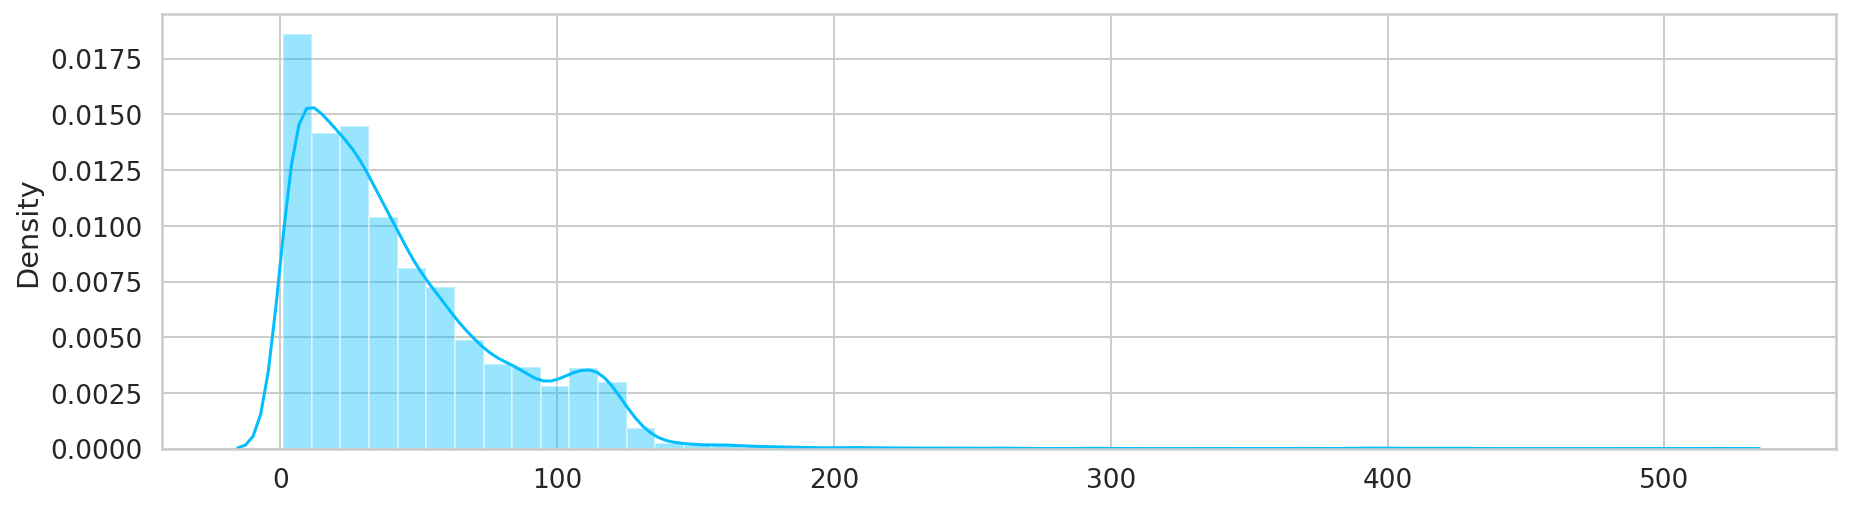

In [18]:
length=[]
for text in df.content:
    tokens=Tokenizer.tokenize(text)
    length.append(len(tokens))
sns.distplot(length)

In [19]:
max_len=160
batch_size=16


In [20]:
class GPReviews(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews=reviews
        self.targets=targets
        self.tokenizer=tokenizer
        self.max_len=max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,index):
        review=str(self.reviews[index])
        target=self.targets[index]
        encoding=self.tokenizer.encode_plus(review,
                               max_length=self.max_len,
                               add_special_tokens=True,
                               
                               pad_to_max_length=True,
                               return_token_type_ids=False,
                               return_attention_mask=True,
                               return_tensors='pt',
                               )
        return {'review':review,
               'input_ids':encoding['input_ids'].flatten(),
               'attention_mask':encoding['attention_mask'].flatten(),
               'target':target}

In [21]:
def create_data_loader(data,tokenizer,batch_size,max_len):
    ds=GPReviews(
    reviews=data.content.to_numpy(),
    targets=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [22]:
train_sp,val_sp=train_test_split(df,test_size=.15,random_state=42)
val_sp,test_sp=train_test_split(val_sp,test_size=.5,random_state=42)
print(train_sp.shape,val_sp.shape,test_sp.shape)

(13384, 12) (1181, 12) (1181, 12)


In [23]:
train_loader=create_data_loader(train_sp,Tokenizer,batch_size,max_len)
val_loader=create_data_loader(val_sp,Tokenizer,batch_size,max_len)
test_loader=create_data_loader(test_sp,Tokenizer,batch_size,max_len)

In [24]:
data=next(iter(train_loader))
data['attention_mask'].shape

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

torch.Size([16, 160])

In [25]:
model=BertModel.from_pretrained('bert-base-cased')
result = model(data['input_ids'],data['attention_mask'])

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
result[0]

tensor([[[ 0.5585,  0.3215,  0.1304,  ..., -0.1965,  0.4893,  0.0379],
         [ 0.5507, -0.1038,  0.2233,  ..., -0.1437,  0.2221,  0.0626],
         [ 0.3829,  0.0783,  0.1376,  ..., -0.0379, -0.2684, -0.1008],
         ...,
         [ 0.2392,  0.1115,  0.1723,  ..., -0.2341,  0.2597,  0.1889],
         [ 0.1516,  0.4152, -0.0351,  ...,  0.0284,  0.1916,  0.1482],
         [ 0.1600,  0.4091, -0.0972,  ...,  0.0334,  0.1929,  0.1271]],

        [[ 0.3585,  0.0149, -0.0422,  ..., -0.3002,  0.1595,  0.0656],
         [ 0.7169, -0.4883,  0.1108,  ..., -0.2854,  0.0379,  0.2677],
         [-0.2729,  0.0802,  0.0226,  ..., -0.0800,  0.4992,  0.2614],
         ...,
         [ 0.1651,  0.0498,  0.2397,  ..., -0.2339, -0.1280, -0.0161],
         [ 0.1564, -0.2785, -0.1043,  ...,  0.0404, -0.1771,  0.2580],
         [ 0.1741,  0.0083,  0.2690,  ..., -0.3165, -0.1754,  0.0700]],

        [[ 0.6478,  0.0663, -0.3227,  ..., -0.2543,  0.1905,  0.2605],
         [ 0.3721, -0.4710,  0.6492,  ..., -0

In [27]:
output=model(data['input_ids'],data['attention_mask'])
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [28]:
class sentimentclassifier(nn.Module):
    def __init__(self,n_classes):
        super(sentimentclassifier,self).__init__()
        self.bert=BertModel.from_pretrained('bert-base-cased')
        self.drop=nn.Dropout(p=0.3)
        self.linear=nn.Linear(self.bert.config.hidden_size,n_classes)
        self.softmax=nn.Softmax(dim=1)        
    def forward(self,input_ids,attention_mask):
        bert_out=self.bert(input_ids,attention_mask)
        drop_out=self.drop(bert_out[1])
        line_out=self.linear(drop_out)
        soft_out=self.softmax(line_out)
        return soft_out

In [29]:
my_model=sentimentclassifier(3)
my_model.to(device)
print('this is text')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


this is text


In [30]:
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'target'])

In [31]:
input_ids=data['input_ids'].to(device)
attention_mask=data['attention_mask'].to(device)
model=model.to(device)
input_ids.shape,attention_mask.shape

(torch.Size([16, 160]), torch.Size([16, 160]))

In [32]:
output= my_model(input_ids,attention_mask)

In [33]:
output.shape

torch.Size([16, 3])

In [34]:
EPOCHS = 10

optimizer = AdamW(my_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [35]:
def train_epoch(data,model,device,optimizer,scheduler,loss_fn,n_examples):
    
    model.train()
    train_loss=[]
    correct_preds=0
    i=1
    for d in data:
        input_ids=d['input_ids'].to(device)
        attention_mask=d['attention_mask'].to(device)
        target=d['target'].to(device)
        
        i=i+1
        if i%100==0:
            print(i)
        output=model(input_ids,attention_mask)
        _,preds=torch.max(output,dim=1)
        
        loss=loss_fn(output,target)
        correct_preds+=torch.sum(preds==target)
        train_loss.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_preds.double()/n_examples,np.mean(train_loss)
        
        
        
        

In [36]:
def val_epoch(data,model,device,loss_fn,n_examples):
    
    model.eval()
    eval_loss=[]
    correct_preds=0
    
    
    with torch.no_grad():
        for d in data:
            input_ids=d['input_ids'].to(device)
            attention_mask=d['attention_mask'].to(device)
            target=d['target'].to(device)
            

            output=model(input_ids,attention_mask)
            _,preds=torch.max(output,dim=1)

            loss=loss_fn(output,target)
            correct_preds+=torch.sum(preds==target)
            eval_loss.append(loss.item())
            
    return correct_preds.double()/n_examples,np.mean(eval_loss)

In [37]:
data=defaultdict(list)
for epoch in range(10):
    
    print(f"{epoch+1}/{10}")
    print("-"*100)
    
    tr_acc,tr_loss=train_epoch(train_loader,my_model,device,optimizer,scheduler,loss_fn,len(train_sp))
    valid_acc,valid_loss=val_epoch(val_loader,my_model,device,loss_fn,len(val_sp))
    data['train_acc'].append(tr_acc.cpu().item())
    data['train_loss'].append(tr_loss)
    data['val_acc'].append(valid_acc.cpu().item())
    data['val_loss'].append(valid_loss)
    print(f"train_accuracy:{tr_acc}                    train_loss:{tr_loss}")
    print(f"val_accuracy  :{valid_acc}                      val_loss:{valid_loss}")
    break
    

1/10
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

100
200
300
400
500
600
700
800


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

train_accuracy:0.6212641960549911                    train_loss:0.9127294213256243
val_accuracy  :0.6977138018628282                      val_loss:0.8412394612222105


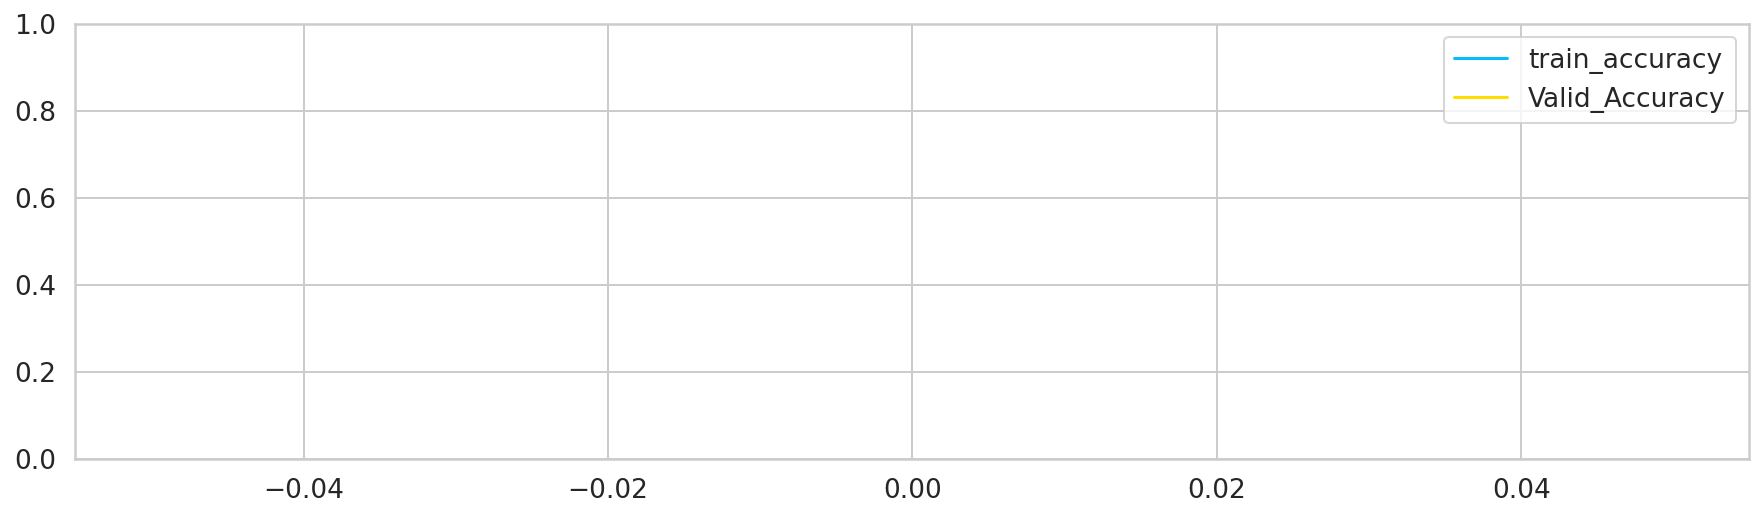

In [38]:
plt.plot(data['train_acc'],label='train_accuracy')
plt.plot(data['val_acc'],label='Valid_Accuracy')
plt.ylim([0,1])
plt.legend()

In [39]:

test_acc,test_loss= val_epoch(test_loader,my_model,device,loss_fn,len(test_sp))
print(f"Test_Accuracy:{test_acc}                 Test_loss:{test_loss}")

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Test_Accuracy:0.6875529212531752                 Test_loss:0.8518979734665638


In [40]:
def get_predictions(model, data_loader):

  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["target"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [41]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

TypeError: max() received an invalid combination of arguments - got (BaseModelOutputWithPoolingAndCrossAttentions, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')